(BART_introduction)=
# Bayesian Additive Regression Trees: Introduction
:::{post} Dec 21, 2021
:tags: BART, non-parametric, regression 
:category: intermediate, explanation
:author: Osvaldo Martin
:::

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = "retina"

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.2+10.g547bcb481


In [2]:
RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## BART overview

Bayesian additive regression trees (BART) is a non-parametric regression approach. If we have some covariates $X$ and we want to use them to model $Y$, a BART model (omitting the priors) can be represented as:

$$Y = f(X) + \epsilon$$

where we use a sum of $m$ [regression trees](https://en.wikipedia.org/wiki/Decision_tree_learning) to model $f$, and $\epsilon$ is some noise. In the most typical examples $\epsilon$ is normally distributed, $\mathcal{N}(0, \sigma)$. So we can also write:

$$Y \sim \mathcal{N}(\mu=BART(X), \sigma)$$

In principle nothing restricts us to use a sum of trees to model other relationship. For example we may have:

$$Y \sim \text{Poisson}(\mu=BART(X))$$

One of the reason BART is Bayesian is the use of priors over the regression trees. The priors are defined in such a way that they favor shallow trees with leaf values close to zero. A key idea is that a single BART-tree is not very good at fitting the data but when we sum many of these trees we get a good and flexible approximation.

## Coal mining with BART

To better understand BART in practice we are going to use the oldie but goldie coal mining disaster dataset. One of the classic examples in PyMC. Instead of thinking this problem as a switch-point model with two Poisson distribution, as in the original PyMC example. We are going to think this problem as a non-parametric regression with a Poisson response (this is usually discussed in terms of [Poisson processes](https://en.wikipedia.org/wiki/Poisson_point_process) or [Cox processes](https://en.wikipedia.org/wiki/Cox_process), but we are OK without going into those technicalities). For a similar example but with Gaussian processes see [1](https://github.com/aloctavodia/BAP/blob/master/code/Chp7/07_Gaussian%20process.ipynb) or [2](https://research.cs.aalto.fi/pml/software/gpstuff/demo_lgcp.shtml). Because our data is just a single column with dates, we need to do some pre-processing. We are going to discretize the data, just as if we were building a histogram. We are going to use the centers of the bins as the variable $X$ and the counts per bin as the variable $Y$

In [3]:
try:
    coal = np.loadtxt(Path("..", "data", "coal.csv"))
except FileNotFoundError:
    coal = np.loadtxt(pm.get_data("coal.csv"))

In [4]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist

In PyMC a BART variable can be defined very similar to other random variables. One important difference is that we have to pass ours Xs and Ys to the BART variable, this information is used when sampling trees, the prior over the sum of trees is so huge that without any information from our data this will be an impossible task. 

Here we are also making explicit that we are going to use a sum over 20 trees (`m=20`). Low number of trees like 20 could be good enough for simple models like this and could also work very good as a quick approximation for more complex models in particular during the early stage of modeling, when we may want to try a few things as quickly as possible in order to better grasp which model may be a good idea for our problem. In those cases once we have more certainty about the model(s) we really like we can improve the approximation by increasing `m`, in the literature is common to find reports of good results with numbers like 50, 100 or 200.

In [5]:
with pm.Model() as model_coal:
    μ_ = pmb.BART("μ_", X=x_data, Y=np.log(y_data), m=20)
    μ = pm.Deterministic("μ", pm.math.exp(μ_))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Before checking the result, we need to discuss one more detail, the BART variable always samples over the real line, meaning that in principle we can get values that go from $-\infty$ to $\infty$. Thus, we may need to transform their values as we would do for standard Generalized Linear Models, for example in the `model_coal` we computed `pm.math.exp(μ_)` because the Poisson distribution is expecting values that go from 0 to $\infty$. This is business as usual, the novelty is that we may need to apply the inverse transformation to the values of `Y`, as we did in the previous model where we took $\log(Y)$. The main reason to do this is that the values of `Y` are used to get a reasonable initial value for the sum of trees and also the variance of the leaf nodes. Thus, applying the inverse transformation is a simple way to improve the efficiency and accuracy of the result. Should we do this for every possible likelihood? Well, no. If we are using BART for the location parameter of distributions like Normal, StudentT, or AssymetricLaplace, we don't need to do anything as the support of these parameters is also the real line. A nontrivial exception is the Bernoulli likelihood (or Binomial with n=1), in that case, we need to apply the logistic function to the BART variable, but there is no need to apply its inverse to transform `Y`, PyMC-BART already takes care of that particular case.

OK, now let's see the result of `model_coal`.

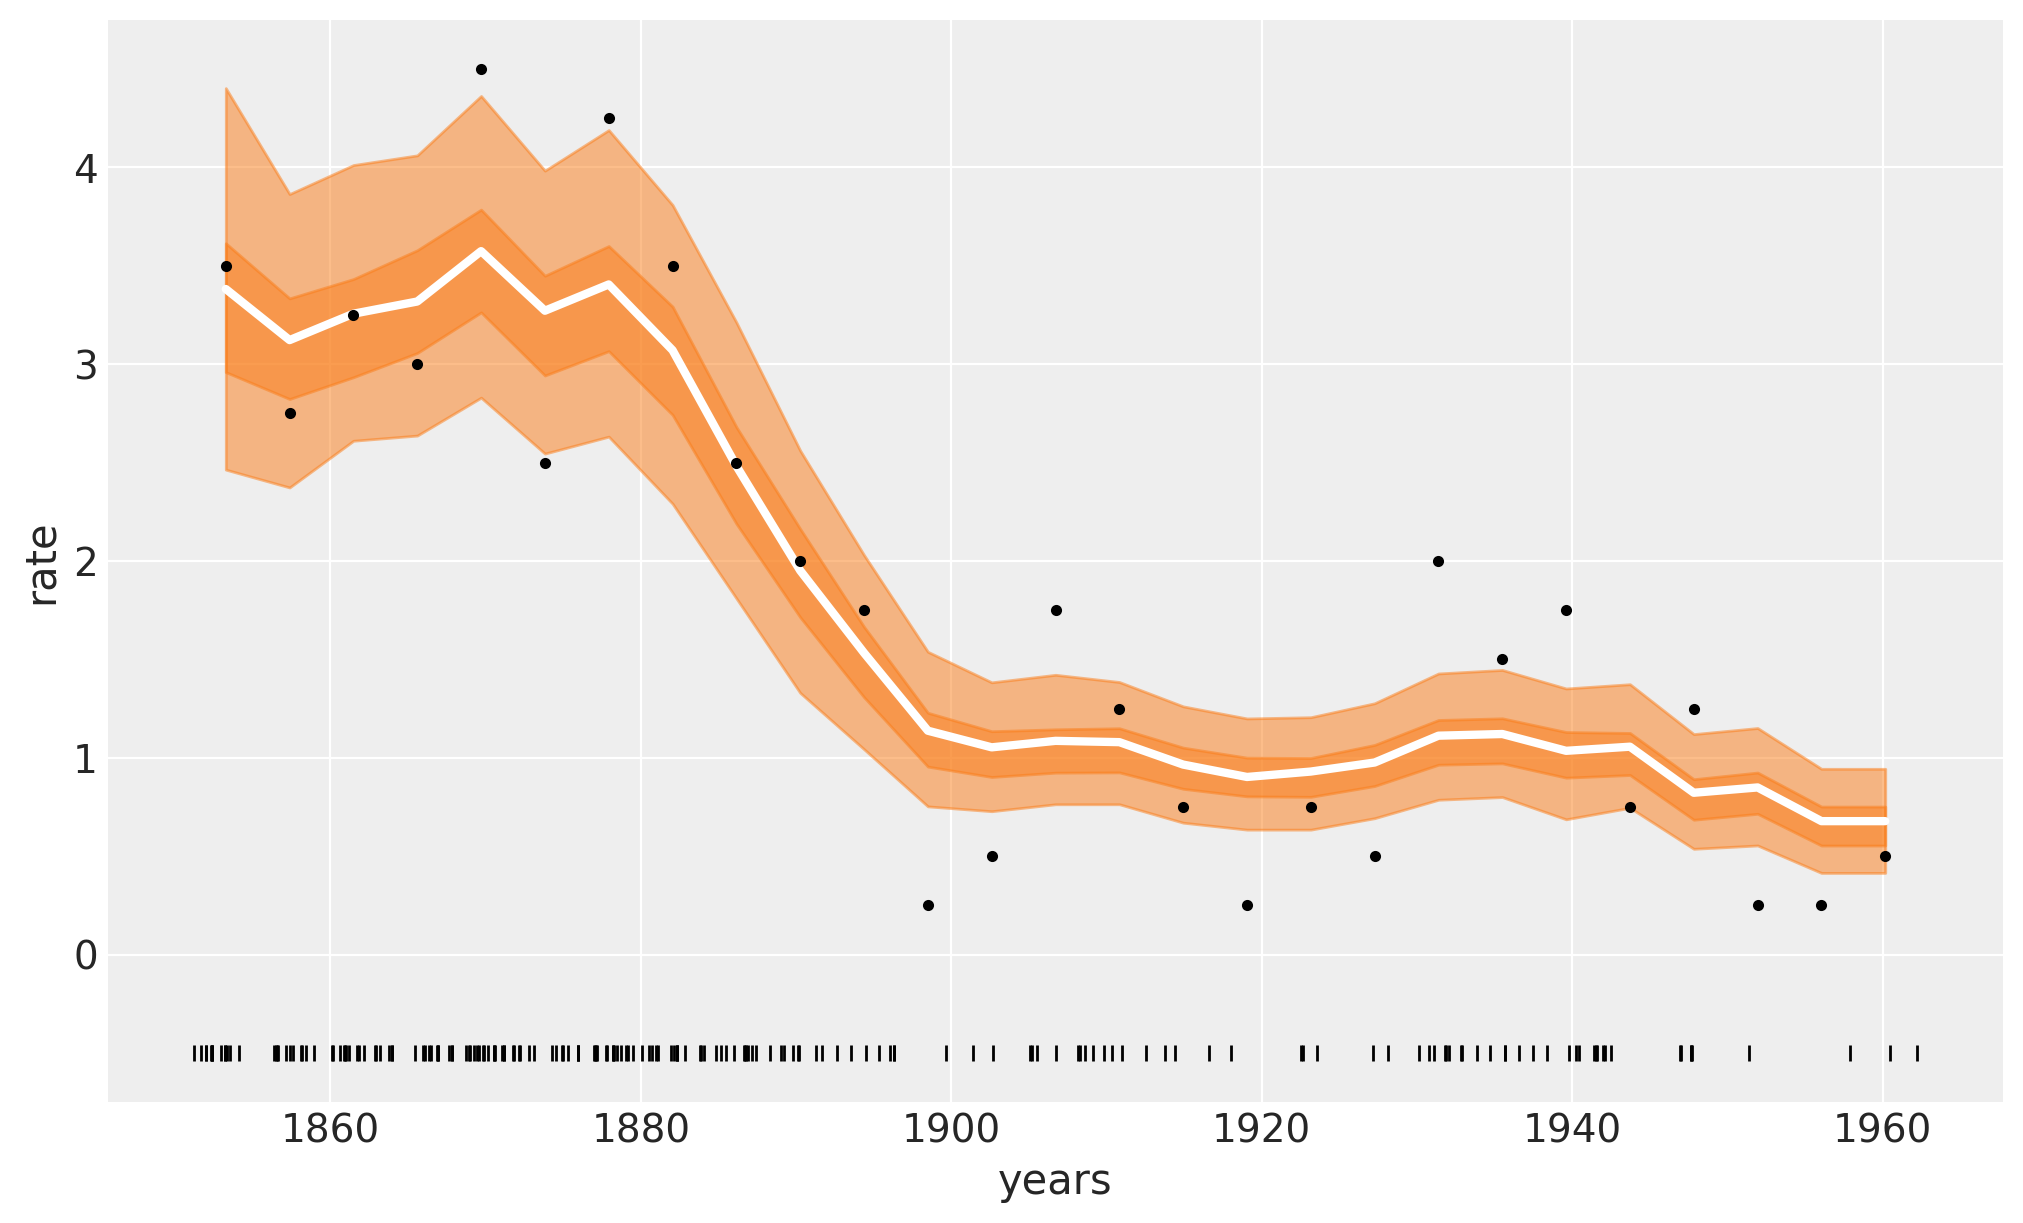

In [6]:
_, ax = plt.subplots(figsize=(10, 6))

rates = idata_coal.posterior["μ"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

The white line in the following plot shows the median rate of accidents. The darker orange band represents the HDI 50% and the lighter one the 94%. We can see a rapid decrease in coal accidents between 1880 and 1900. Feel free to compare these results with those in the original {ref}`pymc:pymc_overview` example.

In the previous plot, the white line is the mean over 4000 posterior draws, and each one of those posterior draws is a sum over `m=20` trees. 


The following figure shows two samples from the posterior of $\mu$. We can see that these functions are not smooth. This is fine and is a direct consequence of using regression trees. Trees can be seen as a way to represent stepwise functions, and a sum of stepwise functions is just another stepwise function. Thus, when using BART we need to know that we are assuming that a stepwise function is a good enough approximation for our problem. In practice, this is often the case because we sum over many trees, usually values like 50, 100, or 200.
Additionally, we often average over the posterior distribution. All this makes the "steps smoother", even when we never really have a smooth function for example with Gaussian processes or splines. A nice theoretical result, tells us that in the limit of $m \to \infty$ the BART prior converges to a [nowheredifferentiable](https://en.wikipedia.org/wiki/Weierstrass_function) Gaussian process.

The following figure shows two samples of $\mu$ from the posterior.

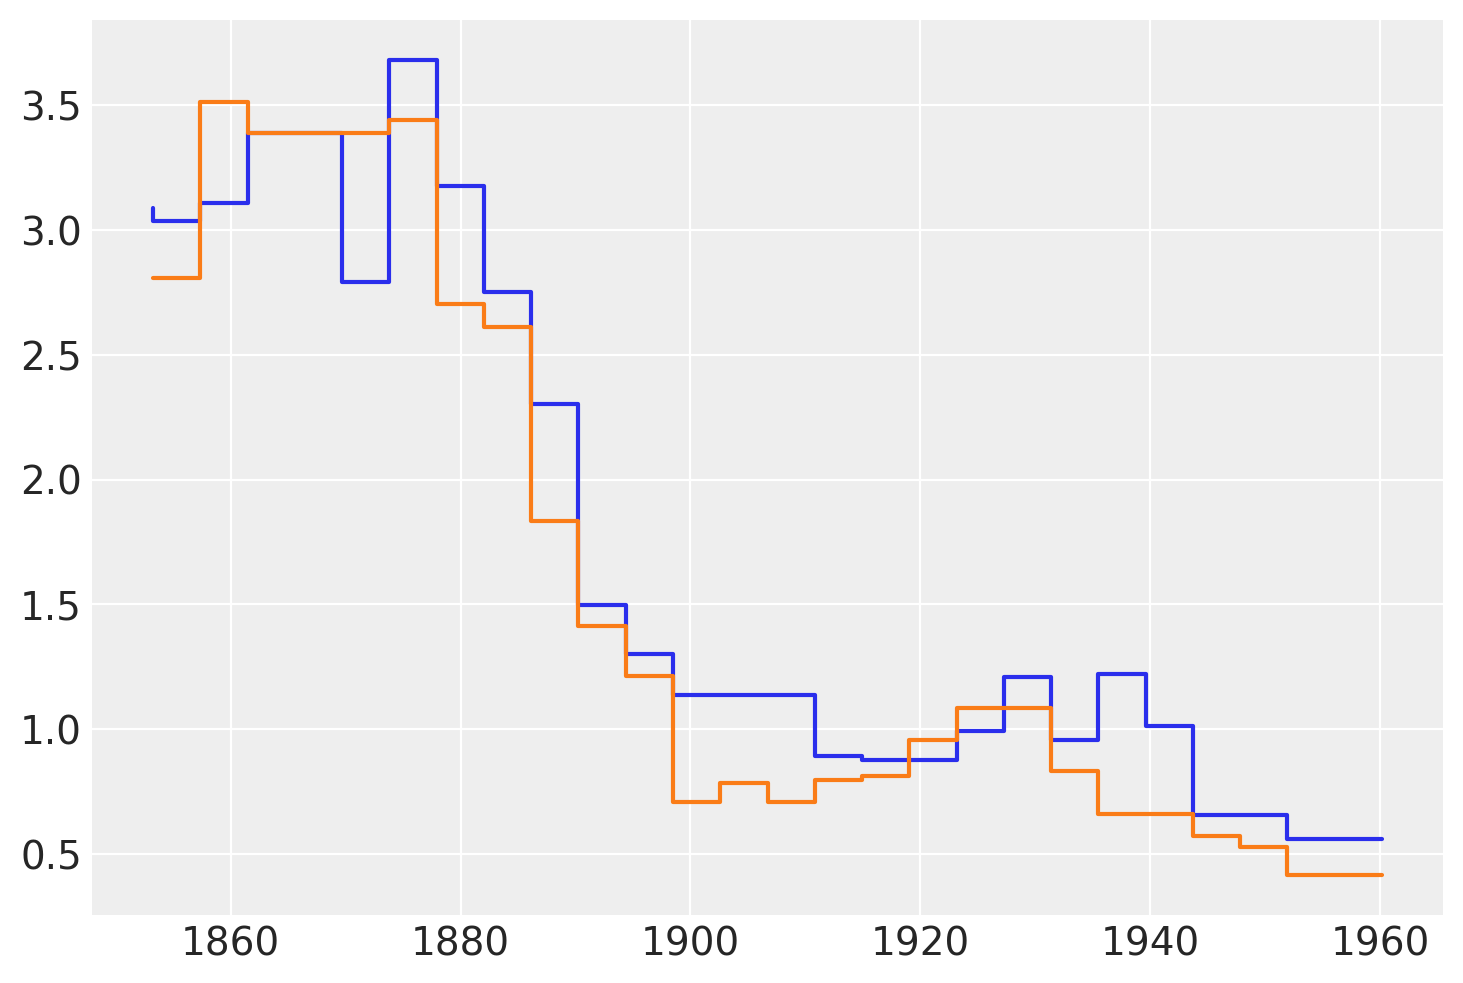

In [7]:
plt.step(x_data, rates.sel(chain=0, draw=[3, 10]).T);

## Biking with BART

To explore other features offered by PyMC-BART. We are now going to move on to a different example. In this example, we have data about the  number of bike rentals in a city, and we have chosen four covariates; the `hour` of the day, the `temperature`, the `humidity`, and whether is a `workingday` or a weekend. This dataset is a subset of the [bike_sharing_dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [8]:
try:
    bikes = pd.read_csv(Path("..", "data", "bikes.csv"))
except FileNotFoundError:
    bikes = pd.read_csv(pm.get_data("bikes.csv"))

features = ["hour", "temperature", "humidity", "workingday"]

X = bikes[features]
Y = bikes["count"]

In [9]:
with pm.Model() as model_bikes:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    idata_bikes = pm.sample(compute_convergence_checks=False, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


### Convergence diagnostics

To check sampling convergence of BART models we recommend a 2 step approach. 

* For the non-BART variables (like $\alpha$ in `model_bikes`) we follow the standard recommendations, like checking R-hat (<= 1.01), and ESS (< 100x number of chains) numerical diagnostics as well as using trace plots or even better rankplots
* For the BART variables we recommend using the `pmb.plot_convergence` function. 

We can see such checks next:

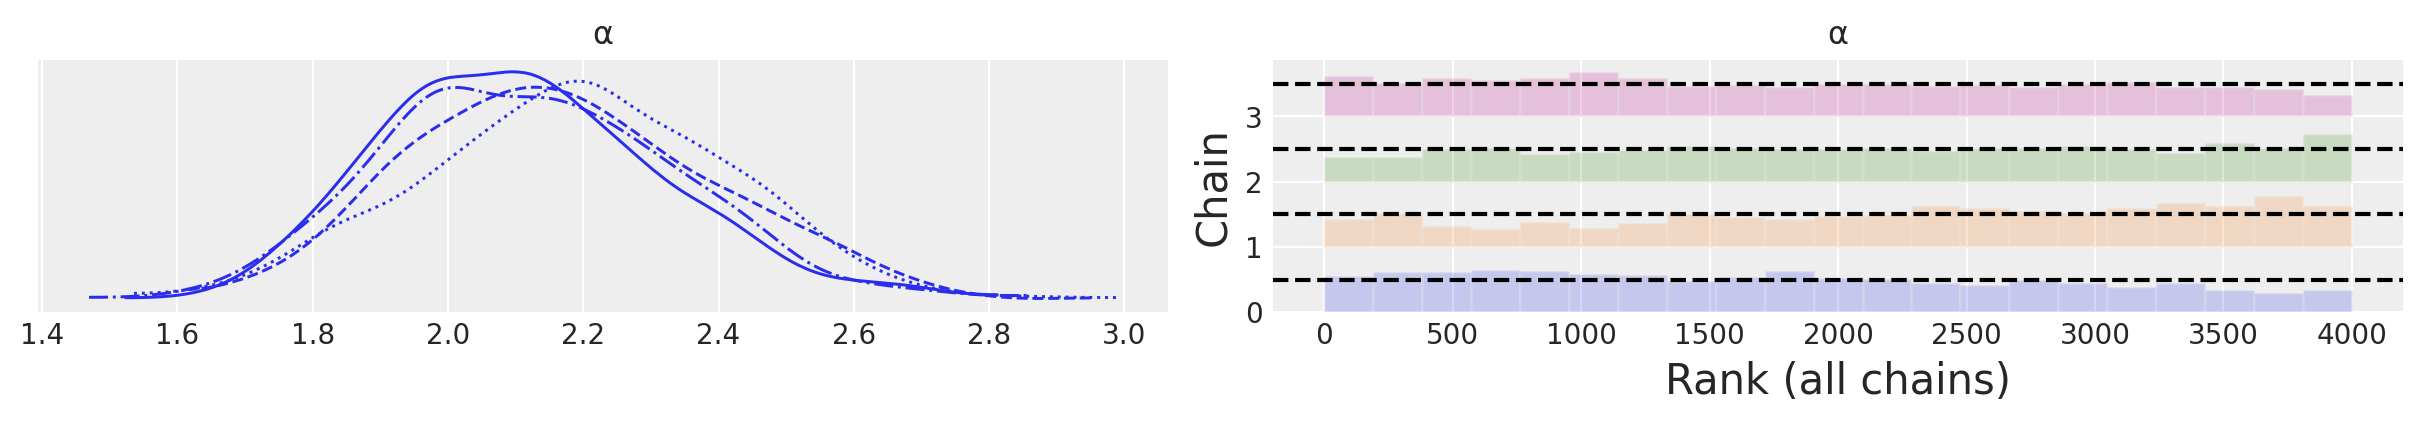

In [10]:
az.plot_trace(idata_bikes, var_names=["α"], kind="rank_bars");

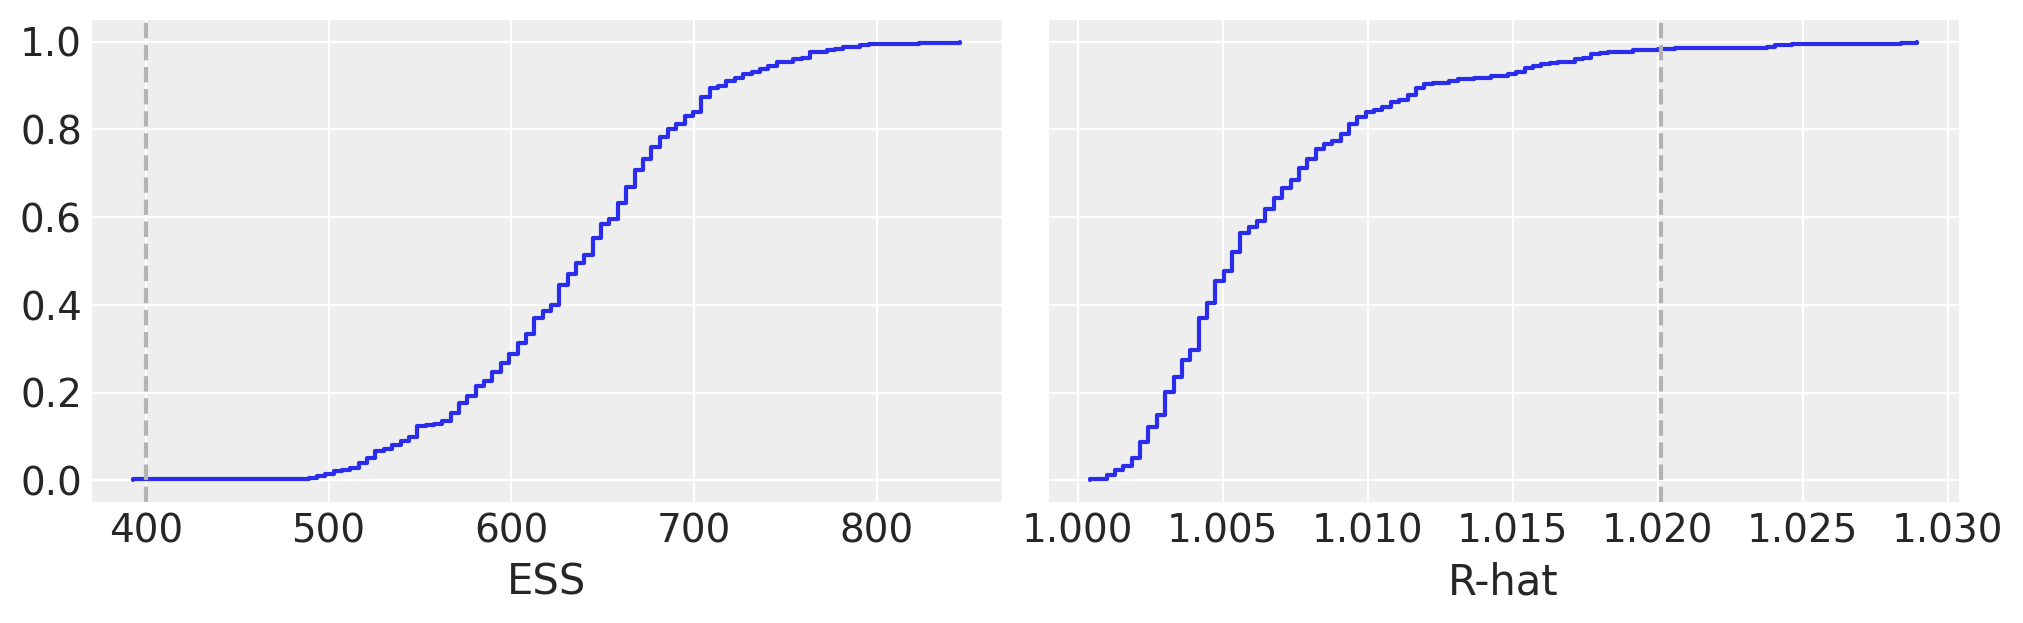

In [11]:
pmb.plot_convergence(idata_bikes, var_name="μ");

In the BART literature, the diagnostics of the BART variables is sometimes considered less important than the diagnostics of the non-BART variables, the main argument is that the individual estimates of the latent variables are of no direct interest, and instead we should only care about how well we are estimating the whole function/regression.

We instead consider checking the convergence of BART variables an important part of the Bayesian workflow. The main reason to use `pmb.plot_convergence` is that usually the BART variable will be a large vector (we estimate a distribution per observation) and thus we will need to check a large number of diagnostics. Additionally, the R-hat threshold of 1.01 is not a hard threshold, this value was chosen assuming one or a few R-hats are examined (and chains are long enough to accurately estimate their autocorrelation), and if we observed a large number of R-hat a few of them are expected to be larger than the 1.01 threshold (or whatever threshold we pick) even if there is nothing wrong with our inference. For that reason, a fair analysis should include a multiple comparison adjustment, and that's what `pmb.plot_convergence` does automatically for you. So, how to read its output? We have two panels one for ESS and one for the R-hat. The blue line is the empirical cumulative distribution for those values, for the ESS we want the entire curve above the dashed line, and for R-hat we want the curve to be entirely below the dashed line. In the previous figure, we can see that we barely make it for the ESS and for the R-hat we have very few values above the threshold. Are our results useless? Most likely not. But to be sure we may want to take a few more draws.  

### Partial dependence plots

To help us interpret the results of our model we are going to use partial dependence plots. This is a type of plot that shows the marginal effect that one covariate has on the predicted variable. That is, what is the effect that a covariate $X_i$ has of $Y$ while we average over all the other covariates ($X_j, \forall j \not = i$). This type of plot is not exclusive to BART. But they are often used in the BART literature. PyMC-BART provides a utility function to make this plot from a BART random variable.

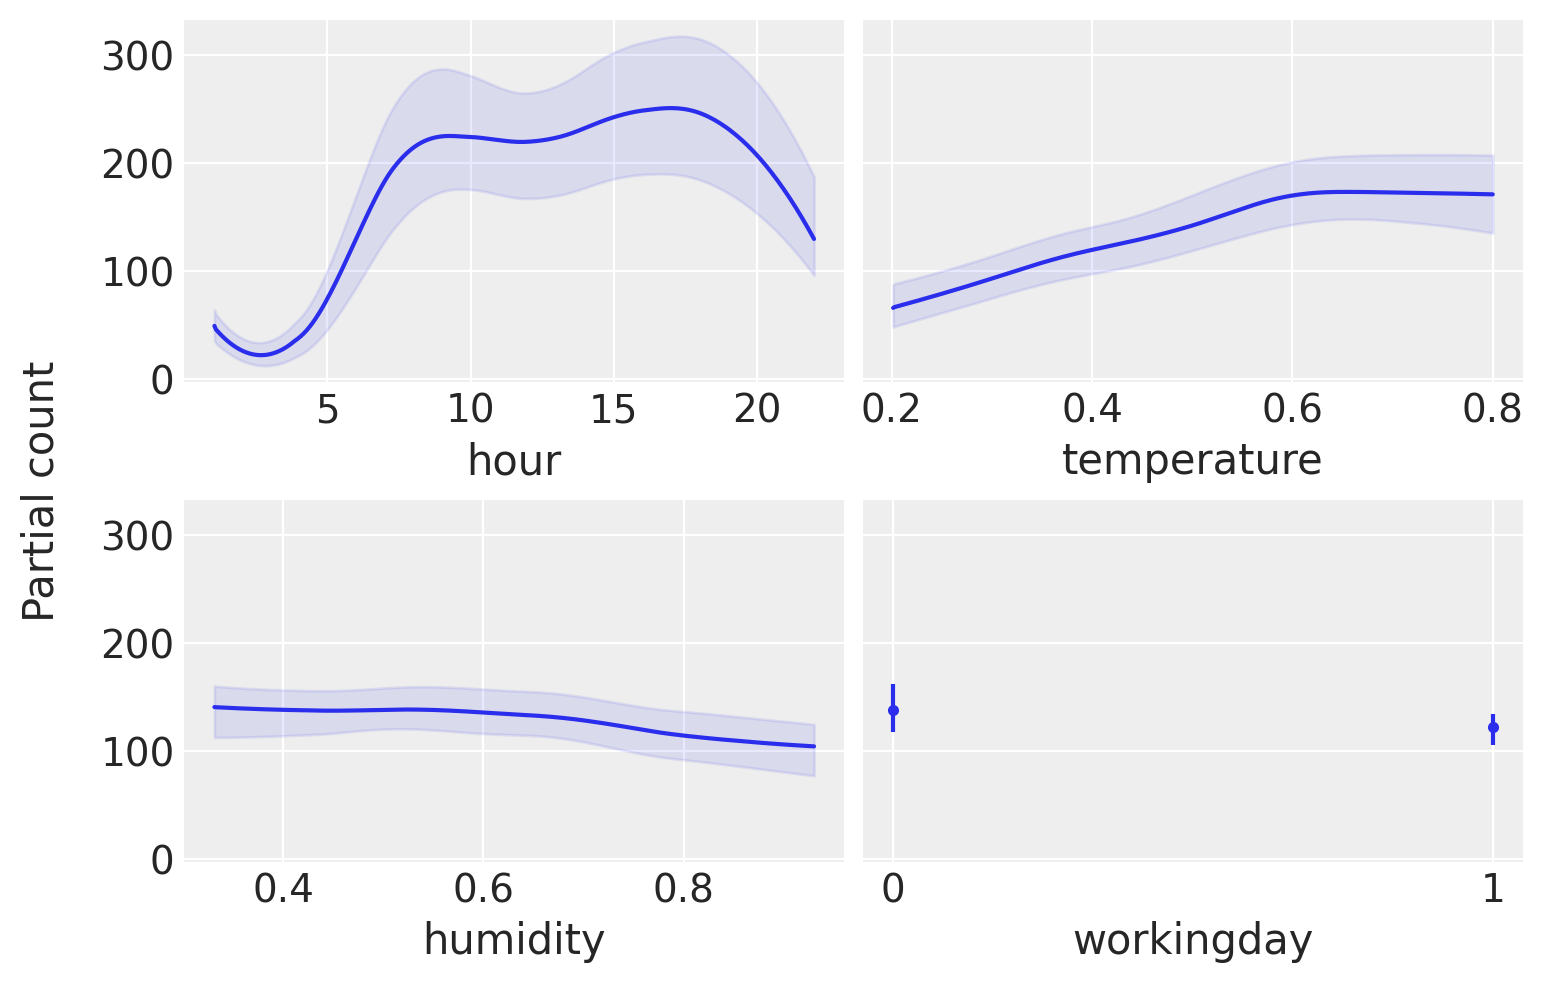

In [12]:
pmb.plot_pdp(μ, X=X, Y=Y, grid=(2, 2), func=np.exp, var_discrete=[3]);

From this plot, we can see the main effect of each covariate on the predicted value. This is very useful as we can recover complex relationships beyond monotonic increasing or decreasing effects. For example for the `hour` covariate we can see two peaks around 8 and 17 hs and a minimum at midnight.

When interpreting partial dependence plots we should be careful about the assumptions in this plot. First, we assume that variables are independent. For example when computing the effect of `hour` we have to marginalize the effect of `temperature` and this means that to compute the partial dependence value at `hour=0` we are including all observed values of temperature, and this may include temperatures that are not observed at midnight, given that lower temperatures are more likely than higher ones. We are seeing only averages, so if for a covariate half the values are positively associated with the predicted variable and the other half negatively associated. The partial dependence plot will be flat as their contributions will cancel each other out. This is a problem that can be solved by using individual conditional expectation plots `pmb.plot_ice(...)`. Notice that all these assumptions are assumptions of the partial dependence plot, not of our model! In fact, BART can easily accommodate interactions of variables Although the prior in BART regularizes high-order interactions). For more on interpreting Machine Learning models, you could check the "Interpretable Machine Learning" book {cite:p}`molnar2019`.

Finally, like with other regression methods, we should be careful that the effects we are seeing on individual variables are conditional on the inclusion of the other variables. So for example, while `humidity` seems to be mostly flat, meaning that this covariate has a small effect on the number of used bikes. This could be the case because `humidity` and `temperature` are correlated to some extent and once we include `temperature` in our model `humidity` does not provide too much extra information. Try for example fitting the model again but this time with `humidity` as the single covariate and then fitting the model again with `hour` as a single covariate. You should see that the result for this single-variate model will be very similar to the previous figure for the `hour` covariate, but less similar for the `humidity` covariate.

### Variable importance

As we saw in the previous section a partial dependence plot can visualize and give us an idea of how much each covariable contributes to the predicted outcome. Moreover, PyMC-BART provides a novel method to assess the importance of each variable in the model. You can see an example in the following figure. 

On the x-axis we have the number of covariables and on the y-axis R² (the the square of the Pearson correlation coefficient) between the predictions made for the full model (all variables included) and the restricted models, those with only a subset of the variables. 

In this example, the most important variable is `hour`, then `temperature`, `humidity`, and finally `workingday`.  Notice that the first value of R², is the value of a model that only includes the variable `hour`, the second R² is for a model with two variables, `hour` and  `temperature`, and so on. Besides this ranking, we can see that even a model with a single component, `hour`, is very close to the full model. Even more, the model with two components `hour`, and `temperature` is on average indistinguishable from the full model. The error bars represent the 94 \% HDI from the posterior predictive distribution. This means that we should expect a model with only `hour` and `temperature` to have a similar predictice performance than a model with the four variables, `hour`,  `temperature`, `humidity`, and `workingday`.

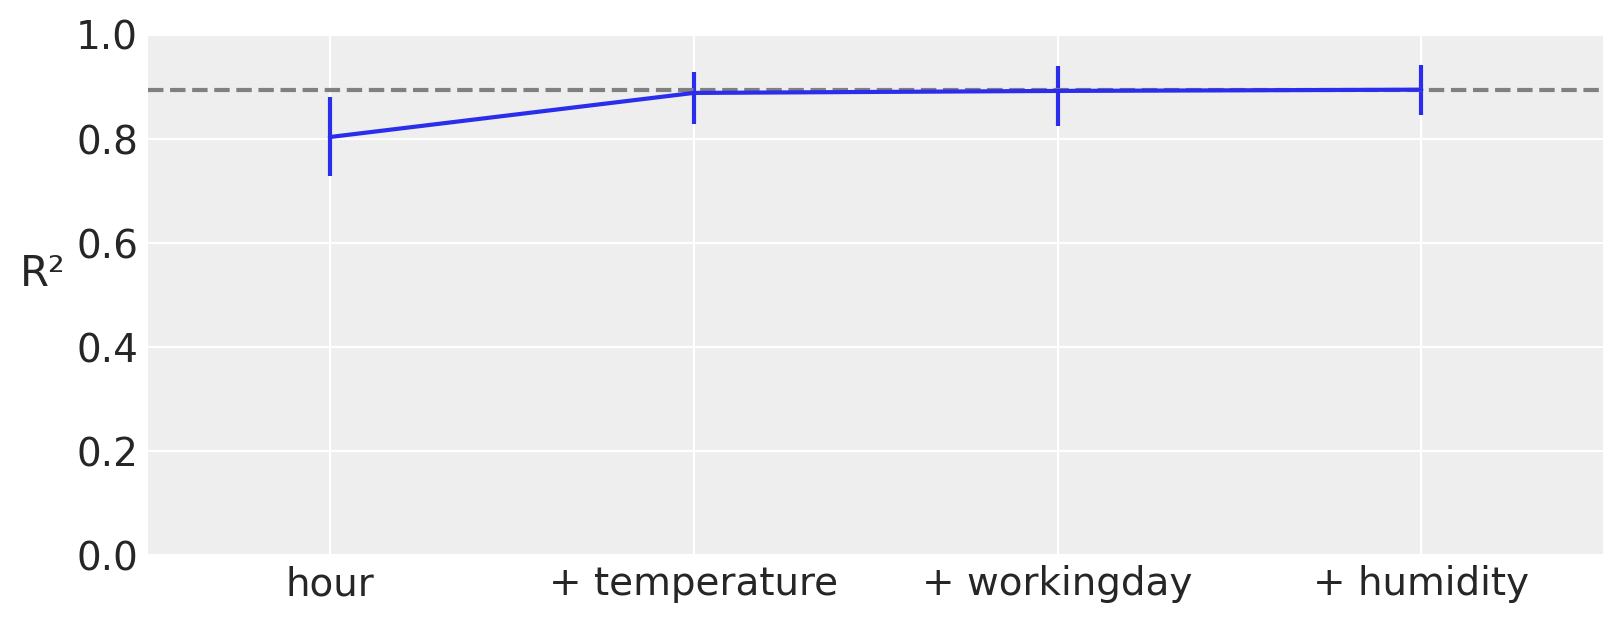

In [13]:
pmb.plot_variable_importance(idata_bikes, μ, X);

`plot_variable_importance` is fast because it makes two assumptions:

* The ranking of the variables is computed with a simple heuristic. We just count how many times a variable is included in all the regression trees. The intuition is that if a variable is important it should appear more often in the fitted trees than less important variables.

* The predictions used for the computation of R² come from the already fitted trees. For instance to estimate the effect of a BART model with the variable `hour` we *prune* the branch that does not include this variable. This makes computations much faster, as we do not need to find a new set of trees.

Instead of using the "counting heuristic". It can also perform a backward search, `pmb.plot_variable_importance(..., method="backward")`. Internally this will compute the R² for the full model, then for all models with one variable less than the full model, and then for all models with less than two, and so on. At each stage, we discard the variable that gives the lowest R². The backward method will be slower, as we need to compute predictions for more models.

### Out-of-Sample Predictions

In this section we want to show how to do out-of-sample predictions with BART. We are going to use the same dataset as before, but this time we are going to split the data into a training and a test set. We are going to use the training set to fit the model and the test set to evaluate the model.

#### Regression

Let's start by modelling this data as a regression problem. In this context we randomly split the data into a training and a test set.

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

Now, we fit the same model as above but this time using a *shared variable* for the covariatates so that we can then replace them to generate the out of sample predictions.

In [15]:
with pm.Model() as model_oos_regression:
    X = pm.MutableData("X", X_train)
    Y = Y_train
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y))
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_regression = pm.sample(random_seed=RANDOM_SEED)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Next, we replace the data in the model and sample from the posterior predictive distribution.

In [16]:
with model_oos_regression:
    X.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Sampling: [y, μ]


Finally, we can compare the posterior predictive distribution with the observed data.

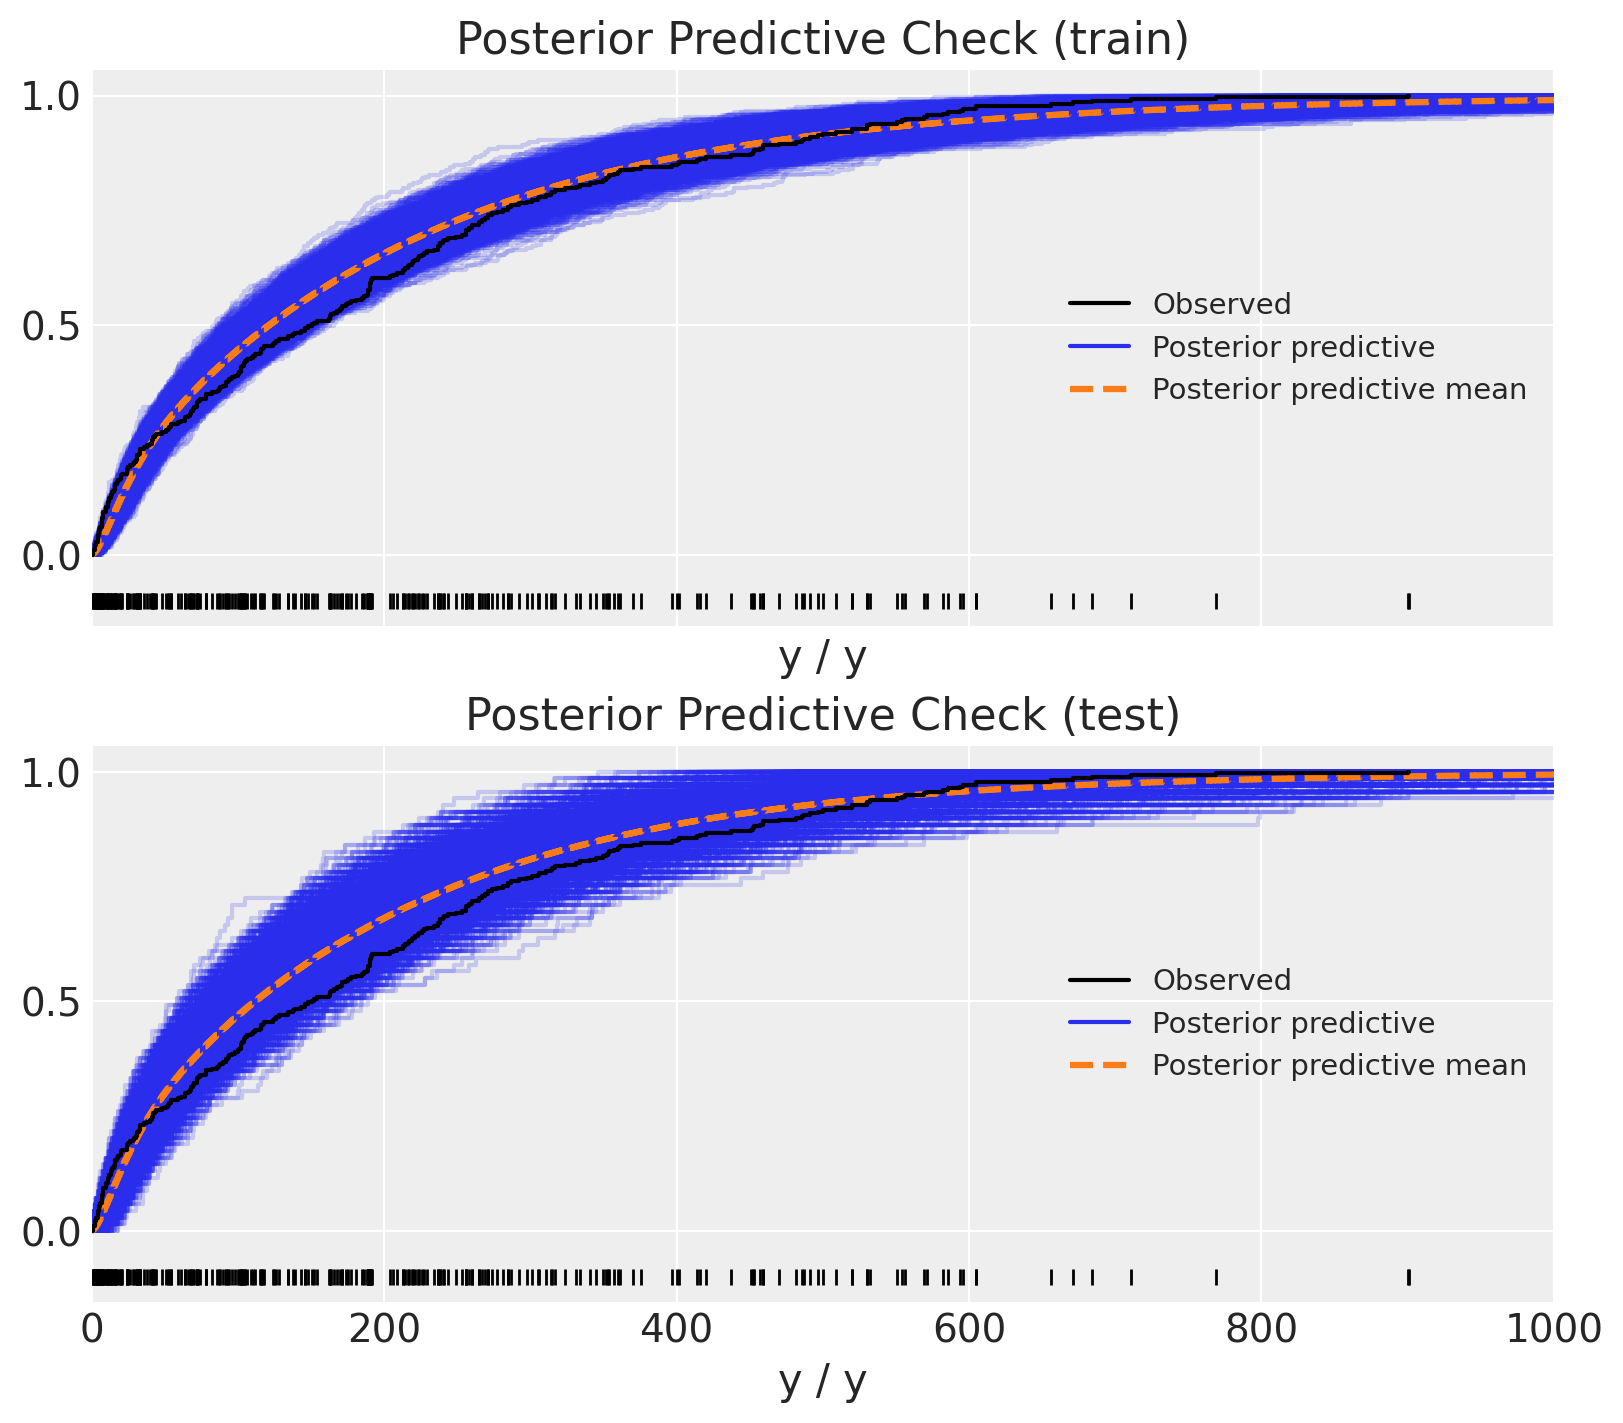

In [17]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
)

az.plot_ppc(
    data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax[0]
)
ax[0].set(title="Posterior Predictive Check (train)", xlim=(0, 1_000))

az.plot_ppc(
    data=posterior_predictive_oos_regression_test, kind="cumulative", observed_rug=True, ax=ax[1]
)
ax[1].set(title="Posterior Predictive Check (test)", xlim=(0, 1_000));

Yay! The results look quite reasonable 🙂!

#### Time Series

We can view the same data from a *time series* perspective using the `hour` feature. From this point of view, we need to make sure we do not shuffle the data so that we do not leak information. Thus, we define th train-test split using the `hour` feature.

In [18]:
train_test_hour_split = 19

train_bikes = bikes.query("hour <= @train_test_hour_split")
test_bikes = bikes.query("hour > @train_test_hour_split")

X_train = train_bikes[features]
Y_train = train_bikes["count"]

X_test = test_bikes[features]
Y_test = test_bikes["count"]

We can then run the same model (but with different input data!) and generate out-of-sample predictions as above.

In [19]:
with pm.Model() as model_oos_ts:
    X = pm.MutableData("X", X_train)
    Y = Y_train
    α = pm.Exponential("α", 1 / 10)
    μ = pmb.BART("μ", X, np.log(Y))
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_ts = pm.sample(random_seed=RANDOM_SEED)
    posterior_predictive_oos_ts_train = pm.sample_posterior_predictive(
        trace=idata_oos_ts, random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


We generate out-of-sample predictions.

In [20]:
with model_oos_ts:
    X.set_value(X_test)
    posterior_predictive_oos_ts_test = pm.sample_posterior_predictive(
        trace=idata_oos_ts, random_seed=RANDOM_SEED
    )

Sampling: [y, μ]


Similarly as above, we can compare the posterior predictive distribution with the observed data.

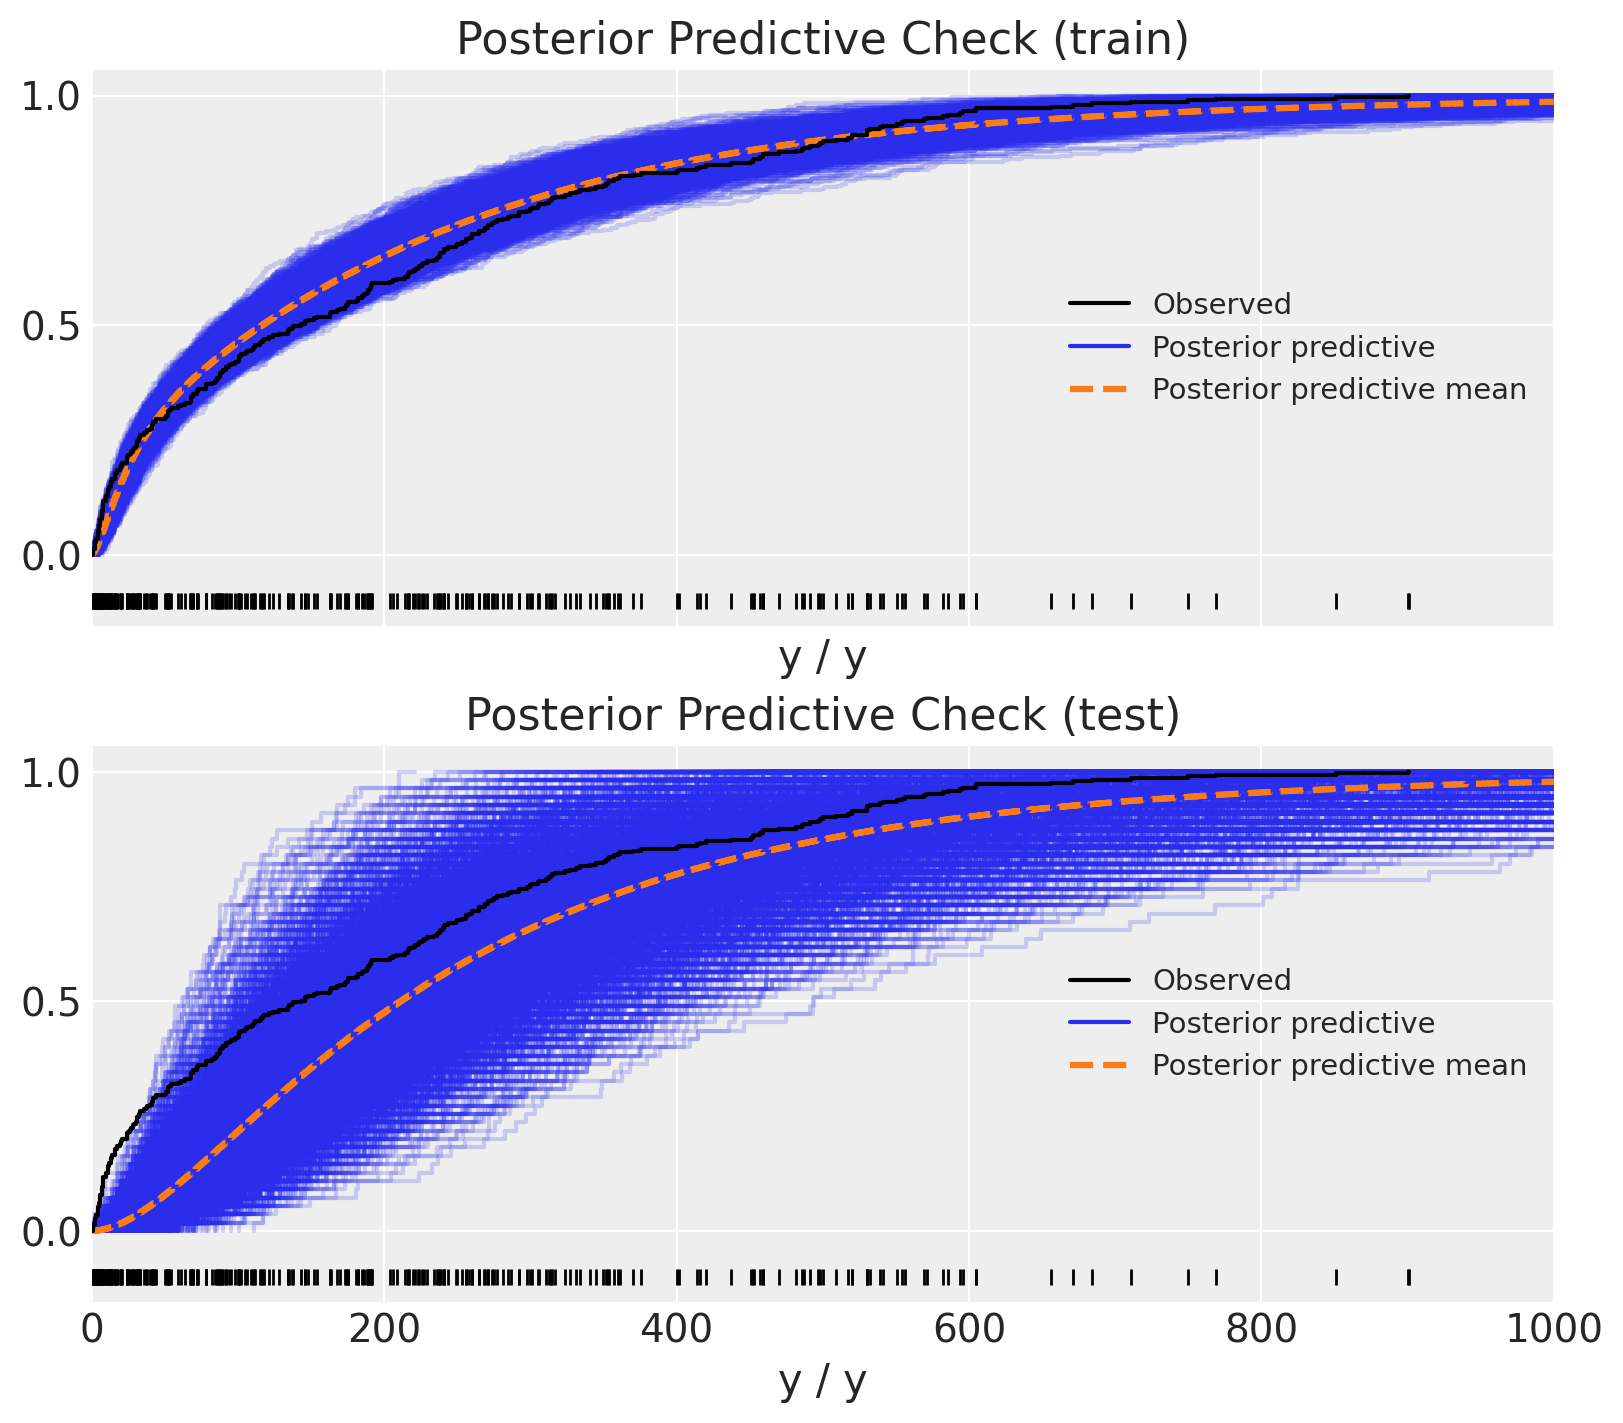

In [21]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
)

az.plot_ppc(data=posterior_predictive_oos_ts_train, kind="cumulative", observed_rug=True, ax=ax[0])
ax[0].set(title="Posterior Predictive Check (train)", xlim=(0, 1_000))

az.plot_ppc(data=posterior_predictive_oos_ts_test, kind="cumulative", observed_rug=True, ax=ax[1])
ax[1].set(title="Posterior Predictive Check (test)", xlim=(0, 1_000));

Wow! This does not look right! The predictions on the test set look very odd 🤔. To better understand what is going on we can plot the predictions as  time series:

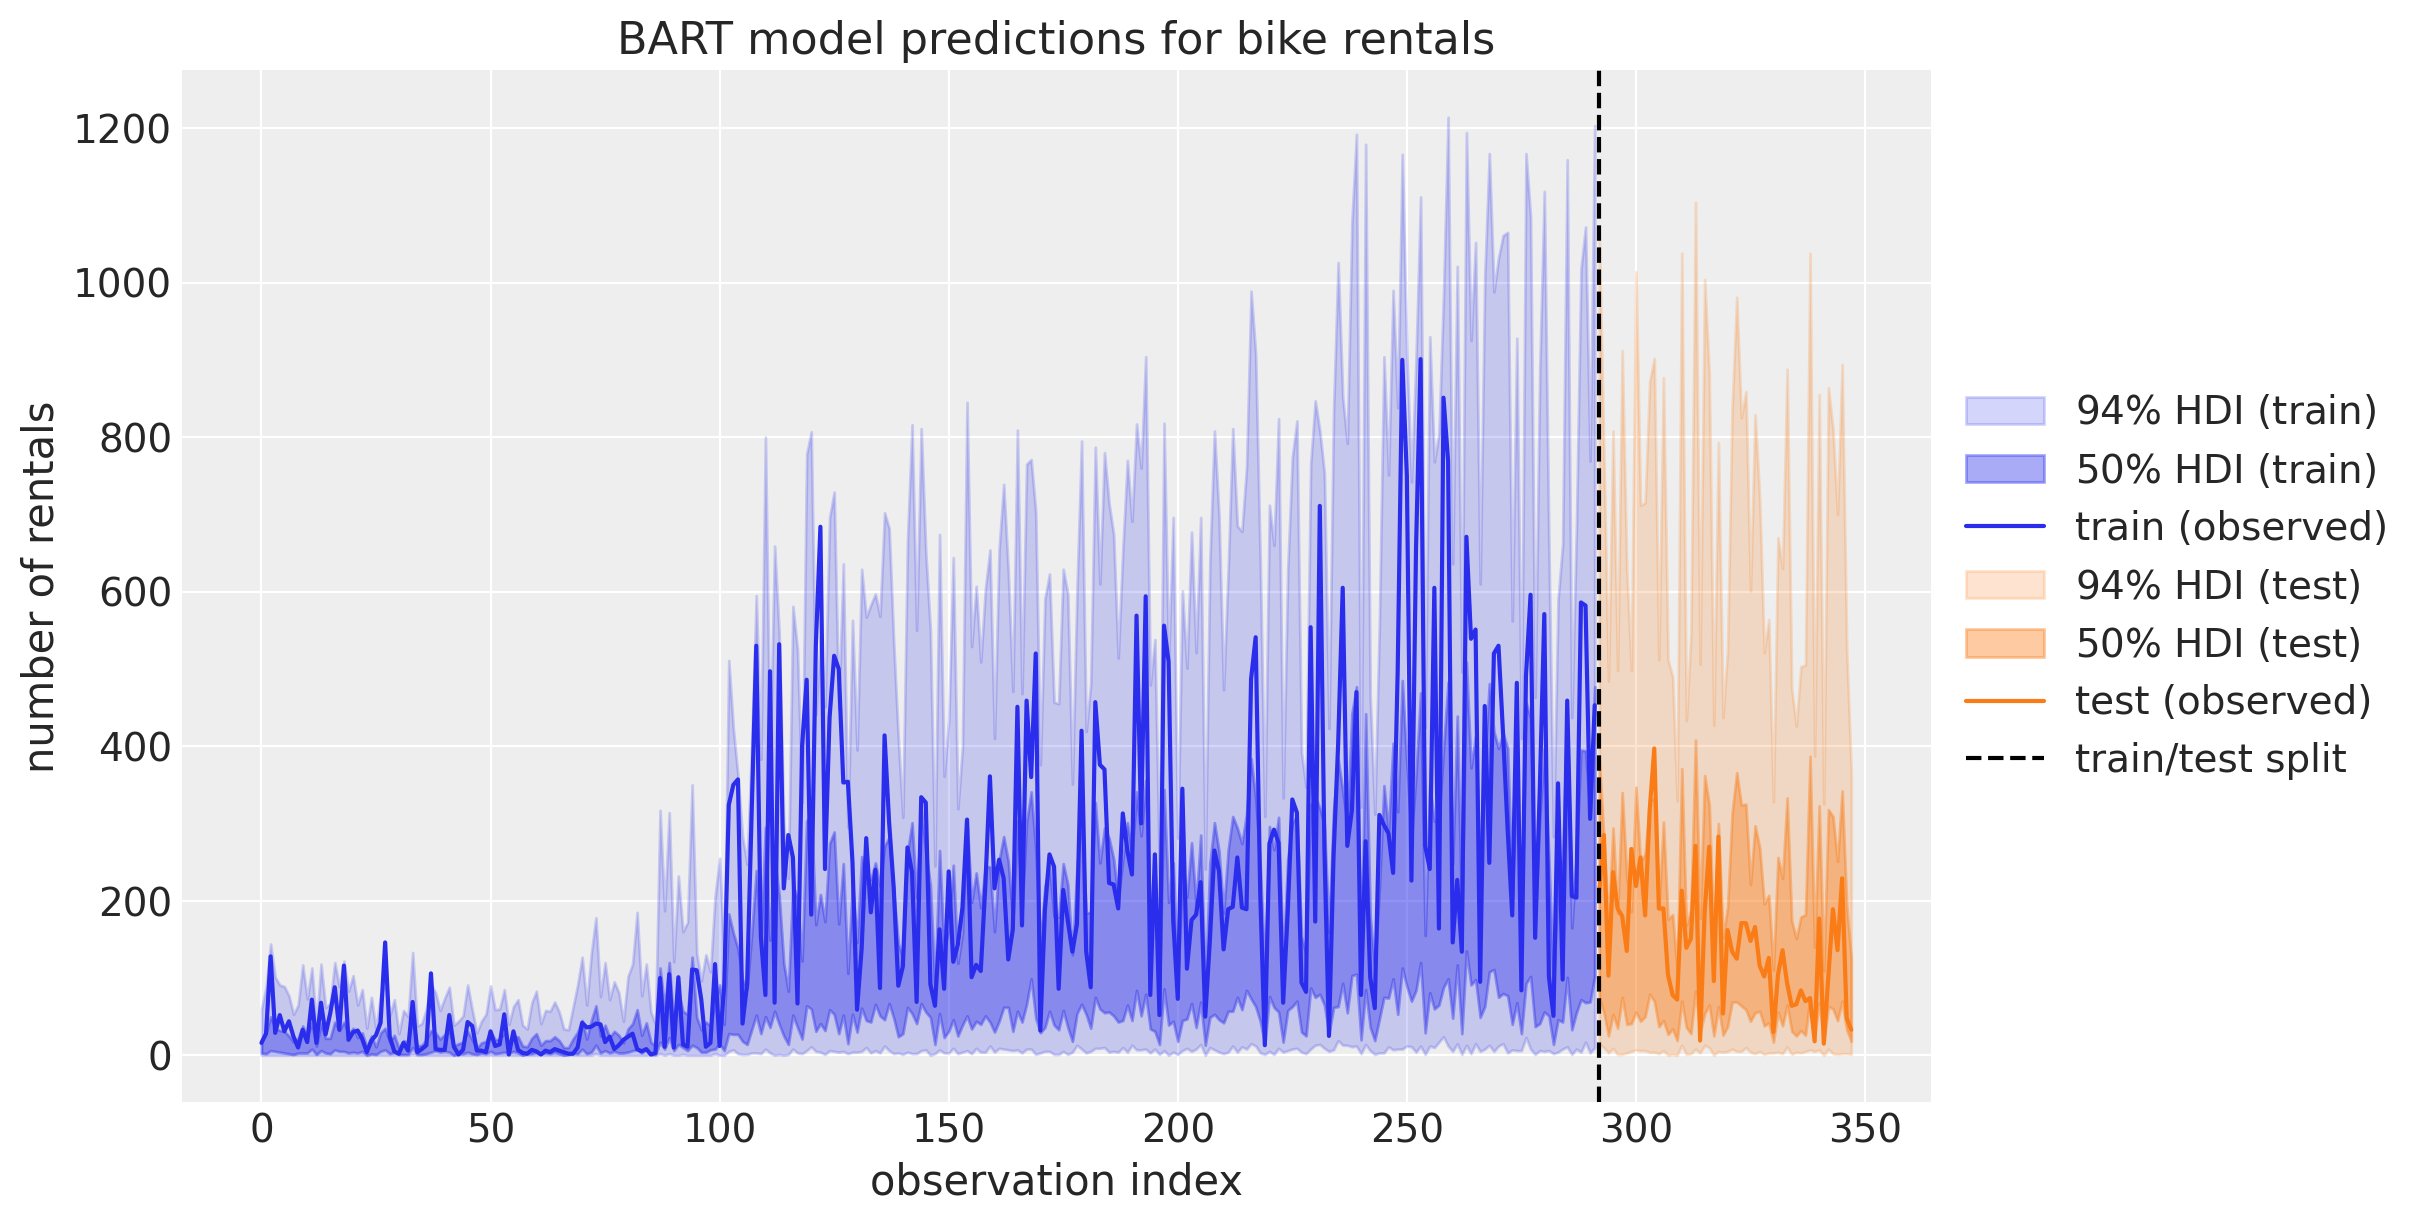

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
az.plot_hdi(
    x=X_train.index,
    y=posterior_predictive_oos_ts_train.posterior_predictive["y"],
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": r"94$\%$ HDI (train)"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=X_train.index,
    y=posterior_predictive_oos_ts_train.posterior_predictive["y"],
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.4, "label": r"50$\%$ HDI (train)"},
    smooth=False,
    ax=ax,
)
ax.plot(X_train.index, Y_train, label="train (observed)")
az.plot_hdi(
    x=X_test.index,
    y=posterior_predictive_oos_ts_test.posterior_predictive["y"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"94$\%$ HDI (test)"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=X_test.index,
    y=posterior_predictive_oos_ts_test.posterior_predictive["y"],
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": r"50$\%$ HDI (test)"},
    smooth=False,
    ax=ax,
)
ax.plot(X_test.index, Y_test, label="test (observed)")
ax.axvline(X_train.shape[0], color="k", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(
    title="BART model predictions for bike rentals",
    xlabel="observation index",
    ylabel="number of rentals",
);

This plot helps us understand the reason behind the bad performance on the test set: Recall that in the variable importance ranking from the initial model we saw that `hour` was the most important predictor. On the other hand, our training data just sees `hour` values until $19$ (since is our train-test threshold). As BART learns how to partition the (training) data, it can not differentiate between `hour` values between $20$ and $22$ for example. It just cares that both values are greater that $19$. This is very important to understand when using BART! This explains why one should not use BART for time series forecasting if there is a trend component. In this case it is better to detrend the data first, model the remainder with BART and model the trend with a different model.

## Authors
* Authored by Osvaldo Martin in Dec, 2021 ([pymc-examples#259](https://github.com/pymc-devs/pymc-examples/pull/259))
* Updated by Osvaldo Martin in May, 2022  ([pymc-examples#323](https://github.com/pymc-devs/pymc-examples/pull/323))
* Updated by Osvaldo Martin in Sep, 2022
* Updated by Osvaldo Martin in Nov, 2022
* Juan Orduz added out-of-sample section in Jan, 2023
* Updated by Osvaldo Martin in Mar, 2023
* Updated by Osvaldo Martin in Nov, 2023

## References

:::{bibliography}
:filter: docname in docnames

martin2021bayesian
quiroga2022bart
:::

## Watermark

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Nov 18 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.16.1

pymc      : 5.9.2+10.g547bcb481
pymc_bart : 0.5.3
numpy     : 1.24.4
matplotlib: 3.8.0
pandas    : 2.1.2
arviz     : 0.16.1

Watermark: 2.4.3



:::{include} ../page_footer.md
:::